In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install wfdb

In [12]:
!python -m pip install heartpy

In [4]:
!pip install -Uqq ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00


In [5]:
#RUTA HECTOR MORA
#path="/content/drive/MyDrive/Colab Notebooks/Errol/BD/"

#RUTA ERROL GARCIA
# path="/content/drive/MyDrive/Trabajo de Grado/Estudio_ML_ECG/BD/"
path='/content/drive/MyDrive/INV_UDNAR/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/'

# Listar archivos en el directorio y visualizar con los datos con los que contamos

In [6]:
import os

records = [f for f in os.listdir(path) if f.endswith('.dat')]
print("Archivos disponibles:", records)


Archivos disponibles: ['100.dat', '101.dat', '102.dat', '103.dat', '104.dat', '105.dat', '106.dat', '107.dat', '118.dat', '119.dat', '200.dat', '201.dat', '202.dat', '203.dat', '205.dat', '207.dat', '208.dat', '209.dat', '210.dat', '212.dat', '213.dat', '214.dat', '215.dat', '217.dat', '219.dat', '108.dat', '109.dat', '111.dat', '112.dat', '113.dat', '114.dat', '115.dat', '116.dat', '117.dat', '121.dat', '122.dat', '123.dat', '124.dat', '220.dat', '221.dat', '222.dat', '223.dat', '228.dat', '230.dat', '231.dat', '232.dat', '233.dat', '234.dat', 'datosNormalizacion.dat']


In [7]:

import wfdb
from sklearn import preprocessing
from wfdb import processing
import heartpy as hp
import statistics as stats
import pdb
import numpy as np

In [8]:

# Funcion para llamar los registros
def llamado(registr):
    regist=100+registr
    registro=str(regist)
    print(registro)
    size=650000

    registro= str(registro)
    record=wfdb.rdrecord(path+registro,sampto=size)
    print("ruta: ",path+registro)
    print("impresion",path+registro)
    annotation = wfdb.rdann(path+registro,'atr',sampto=size)

    # wfdb.plot_wfdb(record=record,annotation=annotation,title=registro)
    wfdb.plot_wfdb(record=record,title=registro)
    # wfdb.plot_wfdb(record=record)
    id_events=annotation.symbol#etiquetas
    raw_data=record.p_signal#datos sin procesar

    return raw_data,id_events


def filtro(s):
    datosF=[]
    for i in range(len(s)):
        filtered3= hp.filter_signal(s[i], cutoff = [2.7, 12.6], sample_rate = 360.0, order = 3, filtertype='bandpass')
        filtered4=hp.filter_signal(filtered3, cutoff = 0.01, sample_rate = 360.0, filtertype='notch')
        datosF.append(filtered4.tolist())
    return datosF


# Funcion para normalizar la señal
def normalizacion(data):
    data_normal=preprocessing.normalize(data, norm='l2')
    return data_normal

# Funcion para detectar el segmento QRS
def detectorQRS(registr):
    regist=100+registr
    registro=str(regist)
    record = wfdb.rdrecord(path+registro, channels=[0], physical=False)
    qrs_locs = processing.gqrs_detect(d_sig=record.d_signal[:,0], fs=record.fs, adc_gain=record.adc_gain[0], adc_zero=record.adc_zero[0])

    return qrs_locs

# Funcion para segmentar la señal, haciendo de los indices obtenidos del detectoe QRS
def segmentacion(data_normal, qrs_locs):
    s=[]
    o=[]
    indices=[]
    p=[]
    for i in range(len(data_normal)):
        for j in range(len(data_normal[i])):
            s.append(data_normal[i][j])

    for k in range(len(qrs_locs)):
        indices.append(qrs_locs[k])

    indices[:0]=[0]
    l=0
    longitud=len(indices)-1

    while l <longitud:
        desde=indices[l]
        hasta=indices[l+1]
        l+=1

        for m in range(desde*2,hasta*2):
            o.append(s[m])
        p.append(o)
        o=[]
    return p

# Funcion para la Binarización de las etiquetas
def Binarizacion(id_events):
    etiquetas1=[]
    lon=len(id_events)

    for i in range(lon):
        if(id_events[i]=='N' or id_events[i]=='+'):
            etiquetas1.append(0)
        else:
            etiquetas1.append(1)
    return etiquetas1

# Funcion para completar las etiquetas y los datos
def completar(etiquetas2,datosSegmentados):
    etq=[]
    dts=[]

    #Filtro de datos
    datosF=filtro(datosSegmentados)

    #se elimina las etiquetas sobrantes de cada registro
    if(len(etiquetas2) - len(datosF)>0):
        value=len(etiquetas2) - len(datosF)
        for i in range(value):
            etiquetas2.pop()
    if(len(datosF) - len(etiquetas2)>0):
        value=len(datosF) - len(etiquetas2)
        for i in range(value):
            datosF.pop()
    else:
        value=len(datosF)

    etq.append(etiquetas2)
    dts.append(datosF)

    return etq, dts

#Funcion para ajustar los segmentos de los datos
def ajusteDatos(dtsCom):
    listaM=[]
    listaCal=[]
    for i in range(len(dtsCom)):
       listaM.append(len(dtsCom[i]))
    prom=int(float(stats.mean(listaM)))
    lon=0
    for j in range(len(dtsCom)):
        lon=len(dtsCom[j])
        while lon < prom:
            desde2=len(dtsCom[j])-3
            hasta2=len(dtsCom[j])
            for k in range(desde2,hasta2):
                listaCal.append(dtsCom[j][k])
                if(k==hasta2-1):
                    dtsCom[j].append(stats.mean(listaCal)+stats.stdev(listaCal))
                    listaCal=[]
                    lon=len(dtsCom[j])


        while lon > prom:
            dtsCom[j]=dtsCom[j][:-1]
            lon=len(dtsCom[j])
    return dtsCom



In [9]:
# -*- coding: utf-8 -*-

import numpy as np
#from funciones import llamado, normalizacion, detectorQRS, segmentacion, filtro, Binarizacion, completar, ajusteDatos

#se definen Variables
etq=[]
dts=[]
etiquetas=[]
etiquetas1=[]
etiquetas2=[]
datosSeg=[]
datosSegmentados=[]

cta_registros=1


In [13]:
%pdb on

Automatic pdb calling has been turned ON


In [14]:
re = 9
datosSeg=[]
etiquetas1=[]

In [15]:

path2 = '/content/drive/MyDrive/Trabajo de Grado/Estudio_ML_ECG/DB test/'


109
ruta:  /content/drive/MyDrive/INV_UDNAR/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/109
impresion /content/drive/MyDrive/INV_UDNAR/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/109


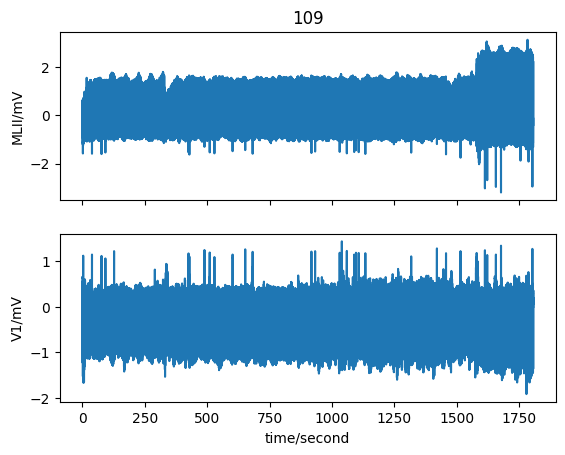

In [16]:
#se llama a los registros
raw_data, id_events=llamado(re)

In [17]:

#se normaliza
data_normal=normalizacion(raw_data)

In [18]:
data_normal

array([[ 0.26568574,  0.96405969],
       [ 0.26568574,  0.96405969],
       [ 0.26568574,  0.96405969],
       ...,
       [-0.93124278,  0.36439935],
       [-0.92812458,  0.37226975],
       [-1.        ,  0.        ]])

In [19]:

np.savetxt(path+'datosNormalizacion.dat',data_normal)

In [20]:

#se hace uso del detector QRS
qrs_locs=detectorQRS(re)

In [21]:

#se hace uso de los indices arrojados por el detector QRS
p=segmentacion(data_normal, qrs_locs)

In [22]:
datosSeg.append(p)

for i in range(len(datosSeg)):
    for j in range(len(datosSeg[i])):
        datosSegmentados.append(datosSeg[i][j])

ll=filtro(datosSegmentados)

In [23]:
#Binarizacion de las etiquetas
etiquetas1.append(Binarizacion(id_events))


for i in range(len(etiquetas1)):
    for j in range(len(etiquetas1[i])):
        etiquetas2.append(etiquetas1[i][j])

101
ruta:  /content/drive/MyDrive/INV_UDNAR/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/101
impresion /content/drive/MyDrive/INV_UDNAR/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/101


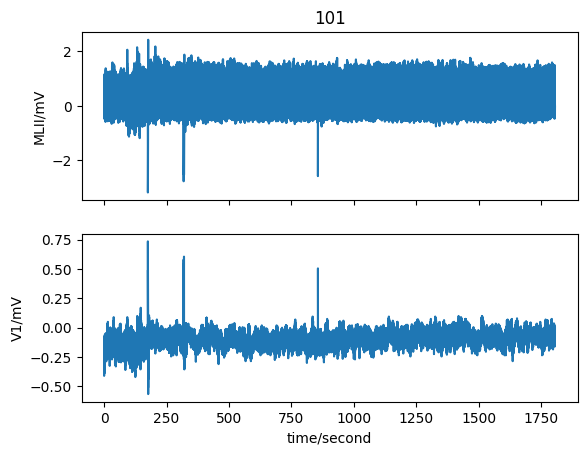

In [24]:
#Se recorren los primeros 20 registros de la base de datos
# for re in range(cta_registros):
re = 1
datosSeg=[]
etiquetas1=[]

# pdb.set_trace()
#se llama a los registros
raw_data, id_events=llamado(re)
#se normaliza
data_normal=normalizacion(raw_data)
#se hace uso del detector QRS
qrs_locs=detectorQRS(re)

#se hace uso de los indices arrojados por el detector QRS
p=segmentacion(data_normal, qrs_locs)

datosSeg.append(p)

for i in range(len(datosSeg)):
    for j in range(len(datosSeg[i])):
        datosSegmentados.append(datosSeg[i][j])

ll=filtro(datosSegmentados)
#Binarizacion de las etiquetas
etiquetas1.append(Binarizacion(id_events))


for i in range(len(etiquetas1)):
    for j in range(len(etiquetas1[i])):
        etiquetas2.append(etiquetas1[i][j])
"""
se completan los datos y las etiquetas con el fin de que tengan la misma
la misma longitud y se realiza el filtro de los mismos
"""
etq, dts = completar(etiquetas2, datosSegmentados)


In [25]:
len(dts)

1

In [26]:
tamano1 = len(dts[0])
tamano2 = len(etq[0])
print(tamano1)
print(tamano2)

4395
4395


402


Text(0.5, 1.0, '1')

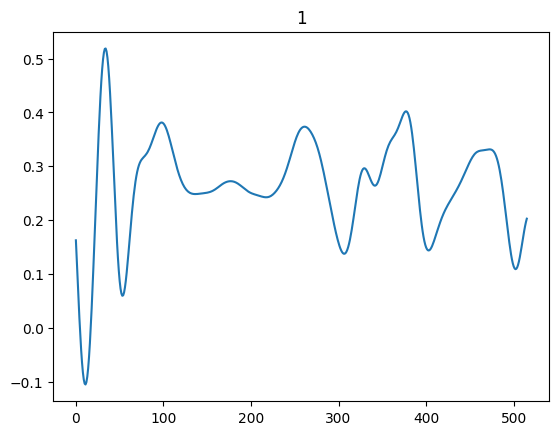

In [27]:
import matplotlib.pyplot as plt
i=np.random.randint(572)
print(i)
plt.plot(dts[0][i])
plt.title(etq[0][i])

In [28]:


dtsCom=[]
etqCom=[]

#se ubica en una sola lista los datos de todos los regitros, asi mismo con las etiquetas
for i in range(len(etq)):
    for j in range(len(etq[i])):
        if(etq[i][j]==1):

            dtsCom.append(dts[i][j])
            etqCom.append(1)
        else:

            dtsCom.append(dts[i][j])
            etqCom.append(0)

#se ajusta los segmentos de datos para que tengan la misma longitud
dtsCom=ajusteDatos(dtsCom)




In [29]:
# path = '/content/drive/MyDrive/Trabajo de Grado/Estudio_ML_ECG/DatosProcesados/register-100'
# path = '/content/drive/MyDrive/Trabajo de Grado/Estudio_ML_ECG/DB test/'

In [30]:
len(dtsCom),len(etqCom)

(4395, 4395)

In [31]:
path

'/content/drive/MyDrive/INV_UDNAR/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/'

In [32]:

#Se guarda los datos
np.savetxt(path+'/Complete/datos.dat',dtsCom)
np.savetxt(path+'/Complete/etiquetas.dat',etqCom)


In [33]:
def dimension_lista(lista):
    if isinstance(lista, list):
        return [len(lista)] + dimension_lista(lista[0])
    else:
        return []

In [ ]:
dimension = dimension_lista(dtsCom)

print("Dimensiones de la lista:", dimension)

Dimensiones de la lista: [4395, 636]


In [34]:
dtsCom[1][1]

-0.4960272008501386

In [35]:
etqCom[1]

1

In [36]:
dtsCom=np.array(dtsCom)

In [37]:
dtsCom.shape

(4395, 591)

In [38]:
import numpy as np

In [43]:
# datos = np.loadtxt("/content/drive/MyDrive/Trabajo de Grado/Estudio_ML_ECG/DB test/datos-101.dat")
# etiquetas = np.loadtxt("/content/drive/MyDrive/Trabajo de Grado/Estudio_ML_ECG/DB test/etiquetas-101.dat")
datos = np.loadtxt(path+'/Complete/datos.dat')
etiquetas = np.loadtxt(path+"/Complete/etiquetas.dat")

In [45]:
etiquetas.shape

(4395,)

In [44]:
datos.shape

(4395, 591)

In [46]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, '[np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]')

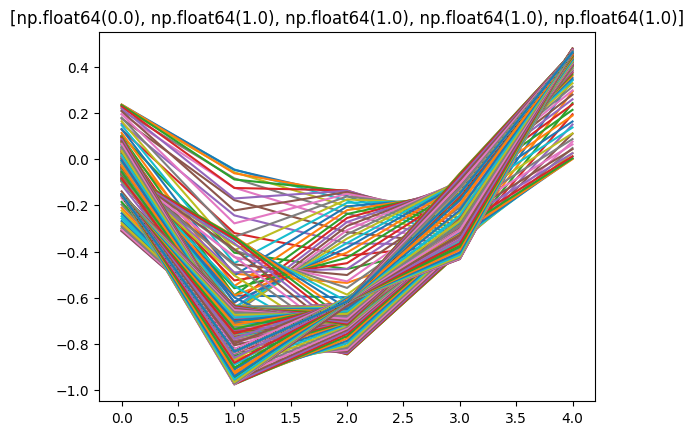

In [47]:
# i=np.random.randint(10)
# print(i)
vtr1 = []
vtr2 = []
for i in range(5):
  vtr1.append(datos[i])
  vtr2.append(etiquetas[i])

plt.plot(vtr1)
plt.title(vtr2)


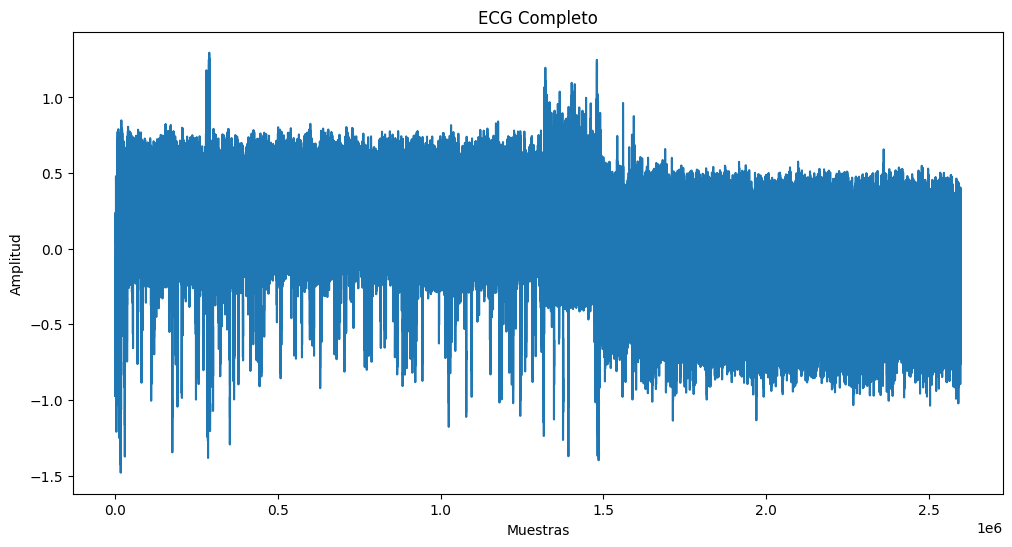

In [48]:
datos_concatenados = datos.flatten()

# Ahora, podemos graficar los datos concatenados usando matplotlib
plt.figure(figsize=(12, 6))
plt.plot(datos_concatenados)
plt.title('ECG Completo')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()

453


Text(0.5, 1.0, '1')

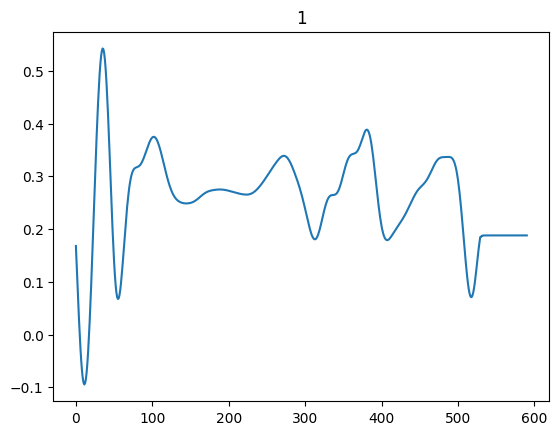

In [49]:
i=np.random.randint(572)
print(i)
plt.plot(dtsCom[i])
plt.title(etqCom[i])

8


Text(0.5, 1.0, '1')

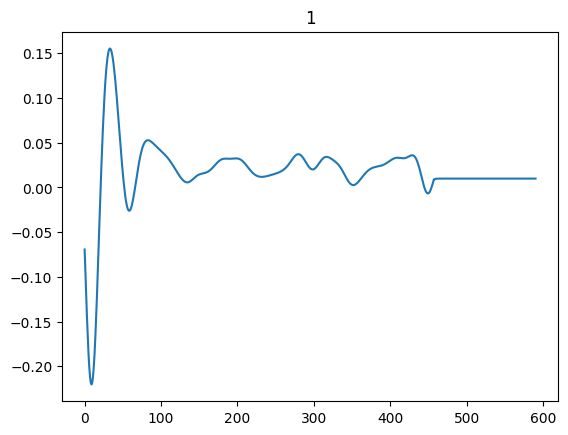

In [50]:
# i=np.random.randint(572)
i=8
print(i)

plt.plot(dtsCom[i])
plt.title(etqCom[i])

In [53]:
etqCom=np.array(etqCom)

In [54]:
etqCom[etqCom==1]

array([1, 1, 1, ..., 1, 1, 1])

Text(0.5, 1.0, '1')

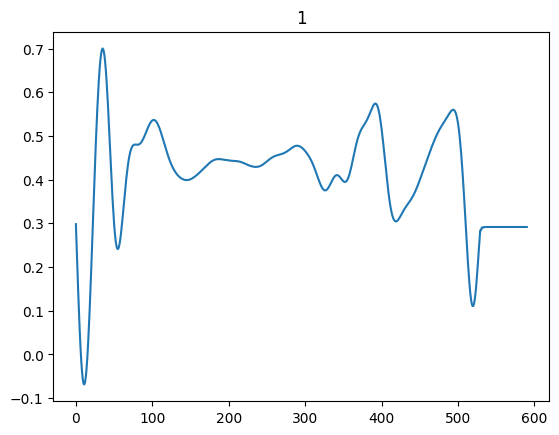

In [55]:
arrithm=etqCom[etqCom==1]
n=arrithm.shape[0]
i=np.random.randint(n)
plt.plot(dtsCom[etqCom==1][i])
plt.title(etqCom[etqCom==1][i])